- **Created by    :** Robby Lysander Aurelio
- **Creation date :** August 19, 2024

In [ ]:
# !pip install nltk
# !pip install torch
# !pip install gensim
# !pip install pyLDAvis

In [1]:
# Load all the necessary library
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import copy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
import re
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn as nn
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
import torch.optim as optim
from itertools import product
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim


d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Part 1:  Text Classification

First, let's start with loading the datasets and check the content

In [2]:
# Load the datasets into a pandas dataframe
df_train = pd.read_csv('./data/train_set.csv')
df_test = pd.read_csv('./data/test_set.csv')

In [3]:
# Check what the dataset looks like
df_train.head(5)

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
0,Large-Scale Study of Curiosity-Driven Learning,Reinforcement learning algorithms rely on ca...,0,0,1
1,Entanglement-assisted quantum error-correcting...,We prove that the known formulae for computi...,1,0,0
2,PromptCBLUE: A Chinese Prompt Tuning Benchmark...,Biomedical language understanding benchmarks...,0,1,0
3,Nonlinear consensus+innovations under correlat...,We consider distributed recursive estimation...,1,0,0
4,Fine-Grained Off-Road Semantic Segmentation an...,Road detection or traversability analysis ha...,0,0,1


In [4]:
# Check the sizes of the datasets
print('Training dataset:', df_train.shape[0])
print('Test dataset:', df_test.shape[0])

Training dataset: 152586
Test dataset: 19074


In [5]:
# Check the proportion of ComputationalLinguistics class
proportion_cl = round(df_train.loc[df_train.ComputationalLinguistics == 1].shape[0] / df_train.shape[0], 2)
print('Proportion of ComputationalLinguistics class in the training data', proportion_cl)

Proportion of ComputationalLinguistics class in the training data 0.27


After that, let's start to prepare the data that are going to be used

In [6]:
# Create the training and test inputs using the only the abstract
train_abstracts = df_train.abstract.tolist()
test_abstracts = df_test.abstract.tolist()

# Create the training and test inputs using only the title
train_titles = df_train.title.tolist()
test_titles = df_test.title.tolist()

# Collect the training and test labels
train_labels = df_train.ComputationalLinguistics.tolist()
test_labels = df_test.ComputationalLinguistics.tolist()

In [7]:
# Download the packages from nltk that are going to be used
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fariz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fariz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fariz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fariz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

This preprocessing function will be used for both algorithm.

In [8]:
# Create a tokenizer & lemmatizer object
class LemmaTokenizer(object):
  '''
  A class to built a tokenizer and lemmatizer function.

  Attributes
  ----------
  wnl : a WordNetLemmatizer() object
    initiate the lemmatizer function.
  stop_words : set
    a set of stop words that are going to be excluded from the training data.
  '''

  def __init__(self):
    '''
    Constructs all the necessary attributes for the LemmaTokenizer object.

    Parameters
    ----------
    wnl : a WordNetLemmatizer() object
      initiate the lemmatizer function
    stop_words : set
      a set of stop words that are going to be excluded from the training data.
    '''

    # Initiate the lemmatizer
    self.wnl = WordNetLemmatizer()

    # Load and preprocess stop words
    self.stop_words = set(stopwords.words('english'))
    self.stop_words = {re.sub(r'\W+', '', word) for word in self.stop_words}

  def __call__(self, text):
    '''
    Enabling the class to behave like functions and can be called like a function.

    Parameters
    ----------
    text : string
      the text to be tokenized and lemmatized.

    Returns
    -------
    A list that contains the tokens that have been lemmatized.
    '''

    # Tokenize the document
    tokens = wordpunct_tokenize(text)
    # Remove symbols, punctuations, and numbers, keeping only alphabets
    tokens = [re.sub(r'[\W+\d+_]', '', t) for t in tokens]
    # Filter out stop words and any empty tokens
    tokens = [t for t in tokens if t and t.lower() not in self.stop_words]
    # Lemmatize the remaining tokens
    return [self.wnl.lemmatize(t) for t in tokens]

### Part 1A: Statistical Method

After preparing the data and the tokenizer, we can start to build the statistical models first. The variations here include:
- **Input type:** using either the abstract or the title of the document.
- **Document size:** using either the first 1,000 or all documents.
- **Feature extraction:** using either the TF-IDF or Count Vectorizer

In [9]:
# Initialize the TF-IDF Vectorizer function
tfidf_vec = TfidfVectorizer(analyzer = 'word', input = 'content',
                        min_df = 3,
                        ngram_range = (1,2),
                        tokenizer = LemmaTokenizer())

# Initialize the Count Vectorizer function
count_vec = CountVectorizer(analyzer = 'word', input = 'content',
                            min_df = 3,
                            ngram_range = (1,2),
                            tokenizer = LemmaTokenizer())

In [10]:
# Initialize the seed for the random number generator
random.seed(79)

# Initialize the combinations that are going to be tested
stat_combinations = list(product([True, False], repeat=3))

# Create an empty list to save the fitted models
stat_models = []

# Create an empty list to save the vectorizers used
vectorizers = []

# Test all the asked combinations
for i, (_abstract, _subset, _tfidf) in enumerate(stat_combinations):
  # Create a copy of the training labels
  # To avoid tampering with the original list
  train_labels_ = train_labels.copy()

  # If the input asked is the abstract,
  # then the training documents will only contain the abstracts
  # Else, use the titles as input
  train_docs = train_abstracts.copy() if _abstract else train_titles.copy()

  # If we are not going to use all training data,
  # pick only the first 1,000 rows
  if _subset:
    train_docs = train_docs[:1000]
    train_labels_ = train_labels_[:1000]

  # We will use two types of vectorizer:
  # TF-IDF and Count Vectorizer
  # Note: here we use the `deepcopy` function to avoid tampering
  # with the original object (avoid to be saved in the same memory)
  vectorizer = copy.deepcopy(tfidf_vec) if _tfidf else copy.deepcopy(count_vec)

  # Shuffle the training data first to avoid unintentional pattern
  train_docs, train_labels_ = shuffle(train_docs, train_labels_)

  # Extract the features from the training documents
  # using the vectorizer
  x_train = vectorizer.fit_transform(train_docs)

  # Convert the training labels into a numpy array
  y_train = np.asarray(train_labels_)

  # Fit the training data to the model
  model = LogisticRegression().fit(x_train, y_train)

  # Save the resulting model
  stat_models.append(model)

  # Save the vectorizer used here
  vectorizers.append(vectorizer)

d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\sklearn\featu

### Part 1B: RNN Method

After building the statistical models, now we can start to build the RNN models. The variations here include:
- **Input type:** using either the abstract or the title of the document.
- **Document size:** using either the first 1,000 or all documents.

In [11]:
# Create a pipeline to preprocess the text
def text_pipeline(x):
  '''
  Creates a pipeline to preprocess the text, which include
  tokenization, then coverted to a vocab.

  Parameters
  ----------
  x : string
    the text to be processed

  Returns
  -------
  A vocab object created from the tokenized and processed text
  '''

  return vocab(tokenizer(x))

def collate_batch(batch):
  '''
  Collects and combines the data in each batch

  Parameters
  ----------
  batch : array
    a batch of data that needs to be combined

  Returns
  -------
  Tensor objects that contain the label and text in each batch.
  If the text is too short, then it will be padded using a special token
  '''

  # Create empty lists to save the labels and texts
  label_list, text_list = [], []

  # Iterate the data in each batch
  for _label, _text in batch:
    # Save the label
    label_list.append(_label)

    # Preprocess the text first before saving it
    # And convert it to a tensor
    processed_text = torch.tensor(text_pipeline(_text), dtype = torch.int64)
    text_list.append(processed_text)

  # Convert the lists into tensors
  # And pad the text lists to create lists with equal length
  return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value = vocab["<pad>"])

# Create a class that dataset
class TextDataset(Dataset):
  '''
  A class to create a dataset object from the text and the label.

  Parameters
  ----------
  data : tensor
    the data pairings, in which the label and text

  Attributes
  ----------
  data : tensor
    the saved dataset from the input
  '''

  def __init__(self, data):
    '''
    Constructs all the necessary attributes for the TextDataset object.

    Parameters
    ----------
    data : tensor
      the data pairings, in which the label and text
    '''

    self.data = data

  def __len__(self):
    '''
    Returns the length of the dataset.

    Returns
    -------
    The number of items in the dataset
    '''

    return len(self.data)

  def __getitem__(self, idx):
    '''
    Returns the data at the specified index.

    Parameters
    ----------
    idx : int
      the index of the data

    Returns
    -------
    The data at the specified index.
    '''

    return self.data[idx]

# Create an object that represent the RNN model
class RNN(nn.Module):
  '''
  A class to create an RNN model.

  Parameters
  ----------
  input_dim : int
    the size of the input layer
  embedding_dim : int
    the size of the embedding layer
  hidden_dim : int
    the size of the hidden layer
  output_dim : int
    the size of the output layer

  Attributes
  ----------
  embedding : torch.nn object
    the embedding layer (from input to embedding)
  rnn : torch.nn object
    the hidden RNN layer (from embedding to hidden)
  fc : torch.nn object
    the output layer (from hidden to output)
  '''

  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    '''
    Constructs all the necessary attributes for the RNN object.

    Parameters
    ----------
    input_dim : int
      the size of the input layer
    embedding_dim : int
      the size of the embedding layer
    hidden_dim : int
      the size of the hidden layer
    output_dim : int
      the size of the output layer
    '''

    # Load the parent/super class which is nn.Module
    super().__init__()

    # Initialize the embedding layer
    self.embedding = nn.Embedding(input_dim, embedding_dim).to(device)

    # Initialize the RNN hidden layer
    self.rnn = nn.RNN(embedding_dim, hidden_dim).to(device)

    # Initialize the output layer
    self.fc = nn.Linear(hidden_dim, output_dim).to(device)

  def forward(self, text):
    '''
    Implements the feedforward step to produce an output
    from the inputted text.

    Parameters
    ----------
    text : tensor
      a sequence of token indices

    Returns
    -------
    The output of the model, which should be the probability of
    belonging to the positive class
    '''

    # Create word embeddings from the inputted text
    embedded = self.embedding(text)

    # Calculate the ouput and hidden value from the embeddings
    # In the hidden layer
    output, hidden = self.rnn(embedded)

    # Check the shape of the output
    assert torch.equal(output[-1,:,:], hidden.squeeze(0))

    # Calculate the output using the output layer from the hidden values
    return self.fc(hidden.squeeze(0))

# Calculate the accuracy of the prediction
def binary_accuracy(preds, y):
  '''
  Calculates the accuracy (in fraction) of the predictions per batch.

  Parameters
  ----------
  preds : tensor
    the predictions ouputted from the model
  y : tensor
    the real labels

  Returns
  -------
  The accuracy per batch.
  '''

  # Round the predictions (probabilities) to the nearest integer
  # (0 or 1)
  rounded_preds = torch.round(torch.sigmoid(preds))

  # Check whether the predictions are correct or not
  correct = (rounded_preds == y).float() # Convert into float for division
  # Calculate the accuracy fraction
  acc = correct.sum() / len(correct)
  return acc

# Training the RNN model
def train(model, dataloader, optimizer, criterion):
  '''
  Trains the RNN model.

  Parameters
  ----------
  model : RNN class object
    the model to be trained
  dataloader : PyTorch DataLoader object
    the loaded traning data
  optimizer : PyTorch Optimizer object
    the optimizer used for the training
  criterion : PyTorch Loss object
    the loss function used for the training

  Returns
  -------
  The training loss and accuracy in this epoch.
  '''

  # Initialize the loss and accuracy
  epoch_loss = 0
  epoch_acc = 0

  # Set the model to training mode
  model.train()

  # Iterate over the data inside the dataloader
  for labels, texts in dataloader:
    # Move the data to the GPU
    texts = texts.to(device)
    labels = labels.to(device)

    # Reset the gradients to zero
    optimizer.zero_grad()

    # Calculate the model predictions
    predictions = model(texts).squeeze(1)

    # Calculate the loss from the prediction results
    loss = criterion(predictions, labels.float())

    # Calculate the accuracy from the prediction results
    acc = binary_accuracy(predictions, labels)

    # Initiate the backpropagation step to calculate the gradients
    loss.backward()

    # Optimize the model parameters using the gradients
    optimizer.step()

    # Update the training loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  # Return the average training loss and accuracy
  return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [12]:
# Set the seed for the random number generator
torch.manual_seed(79)

# Initialize the combinations to be tested
rnn_combinations = list(product([True, False], repeat=2))

# Initialize the device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the tokenizer to be used
tokenizer = LemmaTokenizer()
# Initialize the loss function to be used
criterion = nn.BCEWithLogitsLoss().to(device)

# Initialize the dimensions
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

# Initialize the number of epochs (iterations)
N_EPOCHS = 10

# Create empty lists to save the models and vocabs created
rnn_models = []
vocabs = []

# Create the model for all the combinations
for i, (_abstract, _subset) in enumerate(rnn_combinations):
  # Create a copy of the training labels
  # to avoid tampering with the original
  train_labels_ = train_labels.copy()

  # If the task asks for the abstract,
  # then use the abstracts as the inputs
  # Else use titles
  train_docs = train_abstracts.copy() if _abstract else train_titles.copy()

  # If the task asks for only the subset,
  # then pick the first 1,000 rows
  if _subset:
    train_docs = train_docs[:1000]
    train_labels_ = train_labels_[:1000]

  # Shuffle the training data first to avoid unintentional pattern
  train_docs, train_labels_ = shuffle(train_docs, train_labels_)

  # Build the vocabulary
  vocab = build_vocab_from_iterator((tokenizer(doc) for doc in train_docs), specials=['<unk>'])
  vocab.set_default_index(vocab['<unk>'])
  vocabs.append(vocab)

  # Record the vocabulary size
  vocab_size = len(list(vocab.get_itos()))
  # Use the vocabulary size as the dimension for the input layer
  INPUT_DIM = vocab_size
  # Initiate the RNN model
  model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
  # Initiate the optimizer (here we use SGD)
  optimizer = optim.SGD(model.parameters(), lr=1e-3)

  # Create dataset objects for the training and development set
  train_dataset = TextDataset(list(zip(train_labels_, train_docs)))

  # Load the datasets
  train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_batch)

  # Train the model
  for epoch in range(N_EPOCHS):
    # Start training the model and record the training loss and accuracy
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)

  rnn_models.append(model)
  print()

### Part 1C:  Results for Methods

After training the models, now let's evaluate the models' performance.

In [13]:
# Define the statistical model names
stat_model_names = ['Abstract-Subset-TFIDF', 'Abstract-Subset-Count',
                    'Abstract-All-TFIDF', 'Abstract-All-Count',
                    'Title-Subset-TFIDF', 'Title-Subset-Count',
                    'Title-All-TFIDF', 'Title-All-Count']

# Create empty lists to save the evaluation results
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Create an empty list to save the probabilities
stat_y_probs = []

# Check all resulting models
for i, name in enumerate(stat_model_names):
  # Print the model name
  print(name)

  # Load the model and vectorizer
  model = stat_models[i]
  vectorizer = vectorizers[i]

  # Model 1-4 use the abstracts as input,
  # while model 5-8 use the titles as input instead
  test_docs = test_abstracts.copy() if i < 4 else test_titles.copy()

  # Extract the features from the test documents
  x_test = vectorizer.transform(test_docs)

  # Convert the test labels to array
  y_test = np.asarray(test_labels)

  # Use the model to calculate the prediction probability from the test set
  y_prob = model.predict_proba(x_test) # Probability
  stat_y_probs.append(y_prob)

  # Use the model to predict the label from the test set
  y_predict = model.predict(x_test) # Prediction

  # Print the confusion matrix
  print(confusion_matrix(y_test, y_predict))
  print()

  # Calculate the evaluation metrics and save them
  accuracies.append(accuracy_score(y_test, y_predict))
  precisions.append(precision_score(y_test, y_predict))
  recalls.append(recall_score(y_test, y_predict))
  f1_scores.append(f1_score(y_test, y_predict))

# Create a dataframe to save the evaluation results
stat_results = pd.DataFrame({'Model': stat_model_names,
                             'Accuracy': accuracies,
                             'Precision': precisions,
                             'Recall': recalls,
                             'F1': f1_scores})

stat_results.round(2)

Abstract-Subset-TFIDF
[[13978    90]
 [ 2270  2736]]

Abstract-Subset-Count
[[13746   322]
 [  800  4206]]

Abstract-All-TFIDF
[[13895   173]
 [  295  4711]]

Abstract-All-Count
[[13873   195]
 [  237  4769]]

Title-Subset-TFIDF
[[13874   194]
 [ 2921  2085]]

Title-Subset-Count
[[13661   407]
 [ 2079  2927]]

Title-All-TFIDF
[[13790   278]
 [  574  4432]]

Title-All-Count
[[13778   290]
 [  487  4519]]



,Model,Accuracy,Precision,Recall,F1
0,Abstract-Subset-TFIDF,0.88,0.97,0.55,0.70
1,Abstract-Subset-Count,0.94,0.93,0.84,0.88
2,Abstract-All-TFIDF,0.98,0.96,0.94,0.95
3,Abstract-All-Count,0.98,0.96,0.95,0.96
4,Title-Subset-TFIDF,0.84,0.91,0.42,0.57
5,Title-Subset-Count,0.87,0.88,0.58,0.70
6,Title-All-TFIDF,0.96,0.94,0.89,0.91
7,Title-All-Count,0.96,0.94,0.90,0.92


In [14]:
# Define the RNN model names
rnn_model_names = ['Abstract-Subset', 'Abstract-All',
                 'Title-Subset', 'Title-All']

# Create empty lists to save the evaluation results
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Create an empty list to save the probabilities
rnn_y_probs = []

# Iterate over the models
for i in range(2):
  # Model 1&2 use the abstracts as input,
  # while model 3&4 use the titles as input instead
  test_docs = test_abstracts.copy() if i < 1 else test_titles.copy()

  # Create dataset from the test set and load it to the PyTorch tensor
  test_dataset = TextDataset(list(zip(test_labels, test_docs)))
  test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False, collate_fn = collate_batch)

  # Iterate over the models
  for j in range(2):
    # Calculate the index of the model
    idx = 2*i + j

    # Printe the model name
    print(rnn_model_names[idx])

    # Load the model and vocab
    model = rnn_models[idx]
    vocab = vocabs[idx]

    # Create empty lists to save the prediction results and the actual label
    y_predict = []
    y_prob = []
    y_test = []

    # Set the model to evaluation mode
    model.eval()

    # Set to no capturing the gradient at each step
    with torch.no_grad():
      # Iterate over the data
      for labels, texts in test_dataloader:
        # Move the data to the GPU
        labels = labels.to(device)
        texts = texts.to(device)

        # Make predictions on the test data
        predictions = model(texts).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        # Save the results
        y_predict += rounded_preds.tolist()
        y_prob += predictions.tolist()
        y_test += labels.tolist()

    # Convert the lists into numpy array
    y_predict = np.asarray(y_predict)
    y_prob = np.asarray(y_prob)
    y_test = np.asarray(y_test)

    # Save the probabilities
    rnn_y_probs.append(y_prob)

    # Print the confusion matrix
    print(confusion_matrix(y_test,y_predict))
    print()

    # Calculate the evaluation metrics and save the results
    accuracies.append(accuracy_score(y_test, y_predict))
    precisions.append(precision_score(y_test, y_predict))
    recalls.append(recall_score(y_test, y_predict))
    f1_scores.append(f1_score(y_test, y_predict))

# Create a dataframe to save the evaluation results
rnn_results = pd.DataFrame({'Model': rnn_model_names,
                             'Accuracy': accuracies,
                             'Precision': precisions,
                             'Recall': recalls,
                             'F1': f1_scores})

rnn_results.round(2)

Abstract-Subset
[[13883   185]
 [ 4981    25]]

Abstract-All
[[14068     0]
 [ 5006     0]]

Title-Subset


d:\OneDrive\Documents\Kuliah\S2\03. STUDY\Master Thesis\test\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[13981    87]
 [ 4984    22]]

Title-All
[[13345   723]
 [ 3109  1897]]



,Model,Accuracy,Precision,Recall,F1
0,Abstract-Subset,0.73,0.12,0.00,0.01
1,Abstract-All,0.74,0.00,0.00,0.00
2,Title-Subset,0.73,0.20,0.00,0.01
3,Title-All,0.80,0.72,0.38,0.50


### Part 1D: Plots for Methods

To make it easier to analyse and compare, let's visualise the evaluation results. Then, we can pick the best models from each algorithm and compare them with each other.


In [15]:
def create_barchart(results):
  '''
  Creates a dodged bar chart to compare the evaluation metrics
  from different models.

  Parameters
  ----------
  results : Pandas dataframe
    contains the evaluation metrics for different models

  Returns
  -------
  Print a dodge bar chart that compares the metrics for all models
  '''

  # Convert the dataframe to a "long" format
  results_melt = results.melt(id_vars = 'Model', var_name='Metrics', value_name='Values')

  # Create a dodged barchart to compare the evaluation metrics between the models
  ax = sns.barplot(x = 'Metrics', y = 'Values', hue = 'Model', data = results_melt)
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

  plt.show()

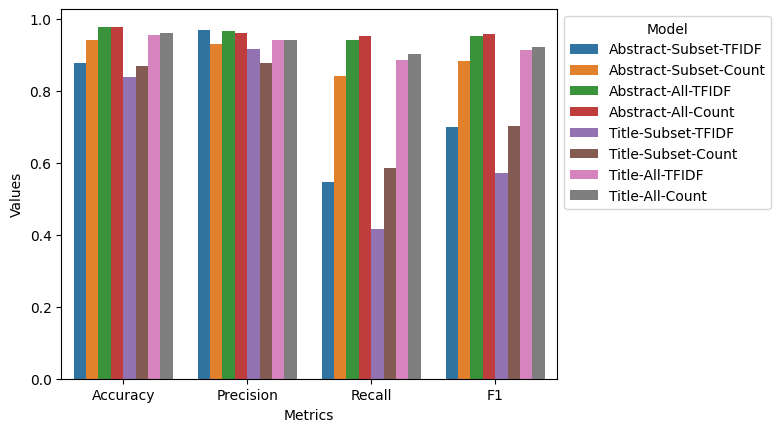

In [16]:
# Print the bar chart for to compare statistical models
create_barchart(stat_results)

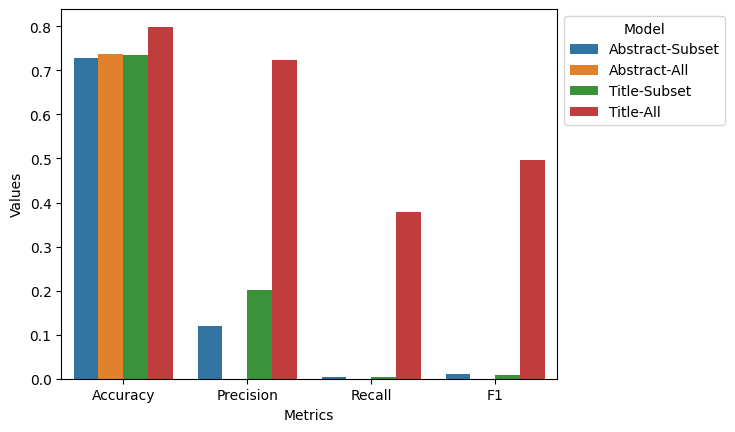

In [17]:
# Print the bar chart to compare the RNN models
create_barchart(rnn_results)

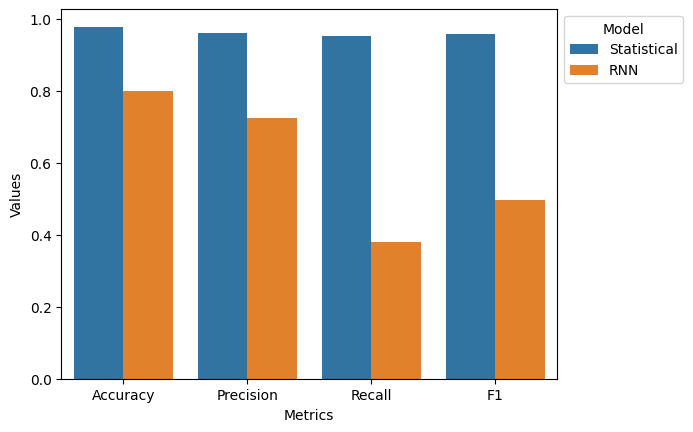

In [18]:
# Save the best models from both methods
best_stat = stat_results[stat_results.Model == 'Abstract-All-Count']
best_rnn = rnn_results[rnn_results.Model == 'Title-All']
best_models = pd.concat([best_stat, best_rnn])

# Rename the model name
best_models['Model'] = best_models.Model.replace({'Abstract-All-Count': 'Statistical', 'Title-All': 'RNN'})

# Create the bar chart for to compare the best models
create_barchart(best_models)

In [19]:
def create_prcurve(y_true, y_scores, name):
  '''
  Creates a Precision-Recall curve for a specific model.

  Parameters
  ----------
  y_true : 1-d array
    the actual labels
  y_scores : 1-d array
    the predicted probabilities
  name : string
    the name of the model

  Returns
  -------
  Print a Precision-Recall curve for the specified model.
  '''

  # Obtain the Precision and Recall scores for different threshold values
  precision, recall, _ = precision_recall_curve(y_true, y_scores)

  # Plot the Precision and Recall scores
  plt.fill_between(recall, precision)
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.title(f'Precision-Recall for the Best {name} Model')

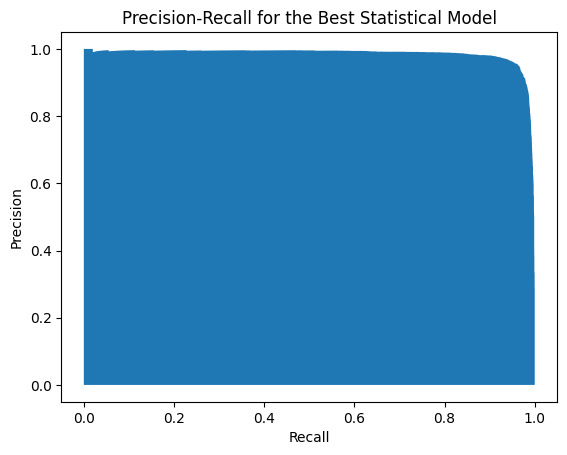

In [20]:
# Save the actual labels
y_true = np.asarray(test_labels)

# Get the predicted probabilities from the best statistical model
stat_y_scores = stat_y_probs[3][:, 1]

# Print the Precision-Recall curve for the best statistical model
create_prcurve(y_true, stat_y_scores, 'Statistical')

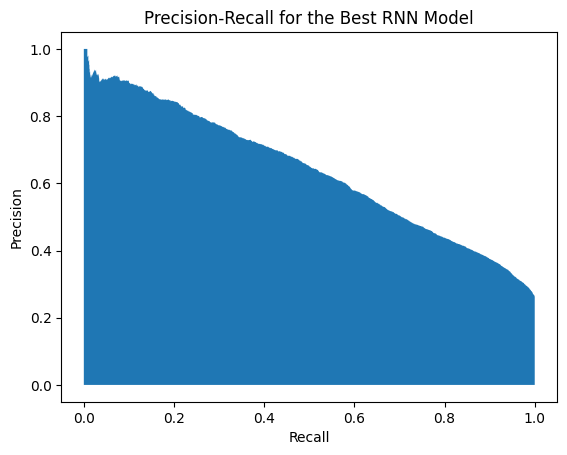

In [21]:
# Get the predicted probabilities from the best RNN model
rnn_y_scores = rnn_y_probs[3]

# Print the Precision-Recall curve for the best statistical model
create_prcurve(y_true, rnn_y_scores, 'RNN')

## Part 2: Topic Modelling

This is the second task, which is the topic modelling using the training data. The variation here is:
- **Documents size:** 1,000 and 20,000 documents.
- Using **bigrams** or not.

Firstly, let's start with building the model.

In [22]:
# Create a tokenizer.
def tokenize(docs):
  '''
  Tokenizes the inputted documents.

  Parameters
  ----------
  docs : list
    documents that contain the texts to be tokenized

  Returns
  -------
  The tokenized documents
  '''

  # Define the tokenizer
  tokenizer = RegexpTokenizer(r'\w+')

  # Split the documents into tokens.
  for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()
    docs[idx] = tokenizer.tokenize(docs[idx])  # Tokenize

  # Remove numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character
  docs = [[token for token in doc if len(token) > 1] for doc in docs]

  return docs

# Add bigrams to the document
def add_bigrams(docs):
  '''
  Adds bigrams to the inputted documents.

  Parameters
  ----------
  docs : list
    a list of documents

  Returns
  -------
  The documents with bigrams
  '''

  # Initialize the bigram extractor
  # Only pick the bigrams that appear in at least 20 times
  bigram = Phrases(docs, min_count=20)

  # Iterate over all documents
  for idx in range(len(docs)):
    # Iterate over all the tokens
    for token in bigram[docs[idx]]:
      # If the token is a bigram, add to document.
      if '_' in token:
        docs[idx].append(token)

  return docs

def prepare_data(docs):
  '''
  Create a dictionary and bag of words representation
  from the inputted documents.

  Parameters
  ----------
  docs : list
    a list of documents

  Returns
  -------
  The resulting dictionary and bag of words representation
  '''

  # Create a dictionary representation of the documents
  dictionary = Dictionary(docs)

  # Filter out words that occur less than 20 documents, or more than 50% of the documents
  dictionary.filter_extremes(no_below=20, no_above=0.5)

  # Create a bag of words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  return dictionary, corpus

In [23]:
# Set the parameters
NUM_TOPICS = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Create a copy of the documents to avoid tampering with the original one
# Here we use the abstracts from the training set as the documents to be modelled
docs = train_abstracts.copy()

# Define the combinations that are going to be tested
combinations = [(1000, False), (1000, True),
                (20000, False), (20000, True)]

# Create empty lists to save the resulting models, corpora, and dictionaries
lda_models = []
corpora = []
dictionaries = []
raw_docs = []

# Test all combinations
for n, bigram in combinations:
  # Create a copy of the documents
  # and pick the first n documents
  docs_ = docs.copy()[:n]

  # Save the raw documents
  raw_docs.append(docs_.copy())

  # Tokenize the documents
  docs_ = tokenize(docs_)

  # If bigram is asked, add bigrams to the documents' tokens
  if bigram:
    docs_ = add_bigrams(docs_)

  # Create a dictionary and bag of words representations of the documents
  dictionary, corpus = prepare_data(docs_)

  # Make a index to word dictionary.
  temp = dictionary[0]  # This is only to "load" the dictionary.
  id2word = dictionary.id2token

  # Initialize the model and train it
  model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=NUM_TOPICS,
      passes=passes,
      eval_every=eval_every,
      random_state = 79)

  # Save the results
  lda_models.append(model)
  corpora.append(corpus)
  dictionaries.append(dictionary)

After building the models, let's use them to cluster the documents into their respective topics, and pick the top 3 documents in each topic.

In [24]:
def get_document_topics(model, corpus, texts):
  '''
  Determines a topic given the document by selecting
  the topic with the highest contribution.

  Parameters
  ----------
  model : gensim LDA model object
    the model used
  corpus : list
    the bag of words representation of the documents
  texts : list
    the original documents

  Returns
  -------
  A dataframe that shows the document belong to which topic number
  with the contibution percentage.
  '''

  # Initialize the output
  document_topics_df = pd.DataFrame()
  data = []

  # Get main topic in each document
  for i, row in enumerate(model[corpus]):
      row = sorted(row, key=lambda x: (x[1]), reverse=True)

      # Get the dominant topic, contribution percentage,
      # and keywords for each document
      for j, (topic_num, prop_topic) in enumerate(row):
          if j == 0:  # => dominant topic
              wp = model.show_topic(topic_num)
              topic_keywords = ", ".join([word for word, prop in wp])
              data.append([int(topic_num+1), round(prop_topic,4), topic_keywords])
          else:
              break

  # Save the results
  document_topics_df = pd.DataFrame(data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

  # Add original text to the end of the output
  document_topics_df['Original_Text'] = pd.Series(texts)

  return document_topics_df

def find_top_k_doc(doc_topic_df, k=3):
  '''
  Gets the top k documents for each topic based
  on the highest contribution percentage.

  Parameters
  ----------
  doc_topic_df : Pandas dataframe
    the topic assignment dataframe
  k : int
    the number of documents to be selected

  Returns
  -------
  A dataframe that shows the top k documents belonging to each topic.
  '''

  # Initialize the output
  doc_topics_sorted_df = pd.DataFrame()

  # Group the documents based on their dominant topic
  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

  # Sort the documents in each topic by the contribution percentage
  # and pick only the top k documents
  for i, grp in doc_topic_df_grpd:
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df,
                                        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)],
                                        axis=0)

  # Reset the index for the sorted dataframe
  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  # Rename the columns
  doc_topics_sorted_df.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']
  return doc_topics_sorted_df

In [25]:
# Create the empty lists to save the result
doc_topics_sorted_dfs = []

# Get the top 3 documents for each topic for each model
for i in range(4):
  document_topics_df = get_document_topics(lda_models[i], corpora[i], raw_docs[i])
  doc_topics_sorted_dfs.append(find_top_k_doc(document_topics_df))

Visualise the clustering resulsts to make it easier to analyse.

In [26]:
lda_display_1 = pyLDAvis.gensim.prepare(lda_models[0], corpora[0], dictionaries[0], sort_topics=False)
pyLDAvis.display(lda_display_1)

In [27]:
doc_topics_sorted_dfs[0]

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9972,"models, model, based, methods, performance, ad...",Existing large language models (LLMs) can on...
1,1,0.9963,"models, model, based, methods, performance, ad...",Software engineering is a domain characteriz...
2,1,0.9962,"models, model, based, methods, performance, ad...",Automatic action quality assessment (AQA) ha...
3,2,0.9969,"language, models, text, model, based, graph, t...",Emotions are experienced and expressed throu...
4,2,0.9964,"language, models, text, model, based, graph, t...",Most popular word embedding techniques invol...
5,2,0.9962,"language, models, text, model, based, graph, t...",Spoken language understanding (SLU) is a tas...
6,3,0.9969,"3d, image, object, method, images, segmentatio...",Existing weakly or semi-supervised semantic ...
7,3,0.9969,"3d, image, object, method, images, segmentatio...",Synthesizing natural interactions between vi...
8,3,0.9966,"3d, image, object, method, images, segmentatio...","In this paper, we present a unified architec..."
9,4,0.9948,"knowledge, language, model, set, these, task, ...",Existing studies in conversational AI mostly...


In [28]:
lda_display_2 = pyLDAvis.gensim.prepare(lda_models[1], corpora[1], dictionaries[1], sort_topics=False)
pyLDAvis.display(lda_display_2)

In [29]:
doc_topics_sorted_dfs[1]

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9975,"based, method, network, proposed, which, metho...",Depth estimation from a single image is of p...
1,1,0.9973,"based, method, network, proposed, which, metho...",Light field (LF) images acquired by hand-hel...
2,1,0.9973,"based, method, network, proposed, which, metho...",Due to the ability to synthesize high-qualit...
3,2,0.9963,"adversarial, codes, attack, which, based, code...","Recently, the evolution of deep learning has..."
4,2,0.9936,"adversarial, codes, attack, which, based, code...",We investigate the fundamental conditions on...
5,2,0.9919,"adversarial, codes, attack, which, based, code...",This paper proposes a new family of recursiv...
6,3,0.9966,"images, segmentation, image, based, performanc...",With an increased interest in applications t...
7,3,0.9965,"images, segmentation, image, based, performanc...",Context. Convolutional neural networks (CNNs...
8,3,0.9963,"images, segmentation, image, based, performanc...",Artistic style transfer is the problem of sy...
9,4,0.9971,"image, data, images, model, video, can, which,...",Annotating a large number of training images...


In [30]:
lda_display_3 = pyLDAvis.gensim.prepare(lda_models[2], corpora[2], dictionaries[2], sort_topics=False)
pyLDAvis.display(lda_display_3)

In [31]:
doc_topics_sorted_dfs[2]

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.8685,"information, features, video, attention, propo...","Recently, many methods of person re-identifi..."
1,1,0.8641,"information, features, video, attention, propo...",Human motion prediction aims to generate fut...
2,1,0.8597,"information, features, video, attention, propo...","Recently, automatic video captioning has att..."
3,2,0.8173,"channel, multiple, user, system, communication...",In this paper we investigate the problem of ...
4,2,0.7829,"channel, multiple, user, system, communication...",The focus of this study is on the spectrum s...
5,2,0.7572,"channel, multiple, user, system, communication...",In this paper we investigate the problem of ...
6,3,0.9018,"network, neural, networks, deep, performance, ...","It has been proven that, compared to using 3..."
7,3,0.8894,"network, neural, networks, deep, performance, ...",Neural Architecture Search (NAS) refers to a...
8,3,0.8759,"network, neural, networks, deep, performance, ...",Batch Normalization (BN) has become a core d...
9,4,0.8282,"models, training, domain, tasks, model, data, ...",We investigate the efficacy of visual prompt...


In [32]:
lda_display_4 = pyLDAvis.gensim.prepare(lda_models[3], corpora[3], dictionaries[3], sort_topics=False)
pyLDAvis.display(lda_display_4)

In [33]:
doc_topics_sorted_dfs[3]

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.8576,"features, information, feature, attention, ima...",Video-based person re-identification aims to...
1,1,0.8319,"features, information, feature, attention, ima...",Existing Transformer-based RGBT tracking met...
2,1,0.8301,"features, information, feature, attention, ima...","In this paper, we present a new multi-branch..."
3,2,0.8731,"data, models, have, has, research, these, such...",Social media platforms have been used for in...
4,2,0.8714,"data, models, have, has, research, these, such...",We give an overview of several of the mathem...
5,2,0.8535,"data, models, have, has, research, these, such...","The rapid increase in fake news, which cause..."
6,3,0.9109,"neural, model, network, networks, deep, based,...",The 8 bits quantization has been widely appl...
7,3,0.9019,"neural, model, network, networks, deep, based,...",Deep neural networks (DNNs) require very lar...
8,3,0.8974,"neural, model, network, networks, deep, based,...",In this paper we propose the first effective...
9,4,0.9062,"language, text, model, models, task, knowledge...","In this paper, we propose an end-to-end sent..."
